In [1]:
import pandas as pd
import numpy as np

# Paths and filenames
data_partition_path = '/data/'
study_data_path = f'{data_partition_path}/UNSAM/CovidProject2/'
results_path = f'{study_data_path}/DataAnalysis/'
response_excel_filename = f'{study_data_path}/Respuestas.xlsx'
summary_excel_filename = f'{study_data_path}/ResumenRespuestas.xlsx'
volunteers_excel_filename = f'{study_data_path}/VoluntariosProyectoCovidProlongado.xlsx'

# Load ASL CSVs
asl_csv_paths = '/home/martin/data/UNSAM/CovidProject2/DataAnalysis/ASL/CleanData/'
scov_gm_filename = f'{asl_csv_paths}/scov_total_gm_clean.csv'

scov_table = pd.read_csv(scov_gm_filename)

# Match groups
summary_table = pd.read_excel(summary_excel_filename, sheet_name='resumenTotal')
indices_scov = []
indices_non_cov = []

for i, pid in enumerate(scov_table['participant_id']):
    ind = summary_table.index[summary_table['ID'] == pid].tolist()
    if ind:
        indices_scov.append(ind[0])
    else:
        print(f'Warning: Subject {pid} not found')
        indices_non_cov.append(i)

summary_table_matched = summary_table.loc[indices_scov].reset_index(drop=True)
group = summary_table_matched['Grupo']
scov_table['group'] = group
scov_table['sex'] = summary_table_matched['Genero']
scov_table['age'] = summary_table_matched['Edad']

print("COVID count:", group.value_counts().get('COVID', 0))
print("CONTROL count:", group.value_counts().get('CONTROL', 0))


COVID count: 145
CONTROL count: 41


In [2]:
# Create a scov table only with the main variables:
main_vars = ['group', 'sex', 'age', 'GM_vol', 'WM_vol', 'CSF_vol', 'WMH_vol', 'WMH_count', 'TotalGM_B', 'TotalGM_L', 'TotalGM_R']
scov_table_main = scov_table[main_vars]
print(scov_table_main)

       group sex  age   GM_vol   WM_vol  CSF_vol  WMH_vol  WMH_count  \
0    CONTROL   F   34  0.66704  0.54910  0.24348    0.130          4   
1    CONTROL   F   50  0.58884  0.49928  0.28673    1.478         24   
2    CONTROL   F   53  0.57372  0.42386  0.35261    0.256          9   
3    CONTROL   M   59  0.68746  0.63414  0.35426    0.563         15   
4    CONTROL   M   39  0.71853  0.58804  0.26506    0.582         21   
..       ...  ..  ...      ...      ...      ...      ...        ...   
181  CONTROL   F   46  0.64699  0.53651  0.31842    1.110         22   
182    COVID   F   58  0.61948  0.51677  0.38505    1.063         10   
183  CONTROL   M   51  0.65738  0.50589  0.30404    0.575         12   
184    COVID   F   47  0.58196  0.53915  0.31059    1.192         19   
185    COVID   M   41  0.69601  0.54617  0.27426    0.723         12   

     TotalGM_B  TotalGM_L  TotalGM_R  
0      0.40994    0.40765    0.40885  
1      0.45300    0.44193    0.45945  
2      0.37926    

In [3]:
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Prepare features and labels
X = scov_table_main.drop(columns=['group'])
y = scov_table_main['group']

# numeric + categorical data
num_cols = ['age', 'GM_vol', 'WM_vol', 'CSF_vol', 'WMH_vol', 'WMH_count', 'TotalGM_B']#, 'TotalGM_L', 'TotalGM_R']
cat_cols = ['sex']

# Pre‑processing, rescale numeric features and one-hot encode categorical features
preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
# Pre‑processing, rescale numeric features and one-hot encode categorical features
X_preprocessed = preprocess.fit_transform(X)

# Find categorical feature indices in the transformed array
cat_indices = [i for i, name in enumerate(preprocess.get_feature_names_out()) if 'cat__' in name]
# Apply SMOTE with categorical variables
smote = SMOTENC(categorical_features=[len(num_cols) + i for i in range(len(cat_cols))],
                sampling_strategy='auto',
                random_state=42)
print(smote)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# Update scov_table and group_shuffled with resampled data
scov_table_smote = X_resampled.copy()
group_smote = y_resampled.copy()
scov_table_smote = pd.DataFrame(scov_table_smote, columns=preprocess.get_feature_names_out())
#scov_table_smote['group'] = group_smote 
indices_shuffle_smote = np.random.permutation(scov_table_smote.shape[0])
scov_table_shuffled_smote = scov_table_smote.iloc[indices_shuffle_smote].reset_index(drop=True)
group_shuffled_smote = group_smote.iloc[indices_shuffle_smote].reset_index(drop=True)

print(scov_table_shuffled_smote)
print("COVID count:", group_smote.value_counts().get('COVID', 0))
print("CONTROL count:", group_smote.value_counts().get('CONTROL', 0))

SMOTENC(categorical_features=[7], random_state=42)
     num__age  num__GM_vol  num__WM_vol  num__CSF_vol  num__WMH_vol  \
0    1.232423    -0.535472    -0.844941      0.149623      0.140121   
1    1.232423     0.354009    -0.238263      0.174947     -0.021943   
2   -1.472605     0.114426    -0.861225     -0.846355     -0.716112   
3   -1.681032     0.615768    -0.392980     -0.755023     -0.626487   
4    0.067041     0.725682     1.124731      1.010089     -0.160551   
..        ...          ...          ...           ...           ...   
285 -1.098341    -0.446435    -0.921284     -0.121034     -0.471886   
286  0.766270    -0.747270     0.063891     -0.643132      0.485575   
287  0.421535     0.992932     0.727797     -0.311453      0.126666   
288 -0.358364     1.808435     1.468443      0.971045     -0.157610   
289 -1.415935     1.770709     1.235379     -0.114633     -0.368053   

     num__WMH_count  num__TotalGM_B  cat__sex_F  cat__sex_M  
0          0.608164        0.43356

1.26.4 3.10.1 0.13.2
(290, 10)
(186, 19)


/tmp/ipykernel_2615822/900960183.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2615822/900960183.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2615822/900960183.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


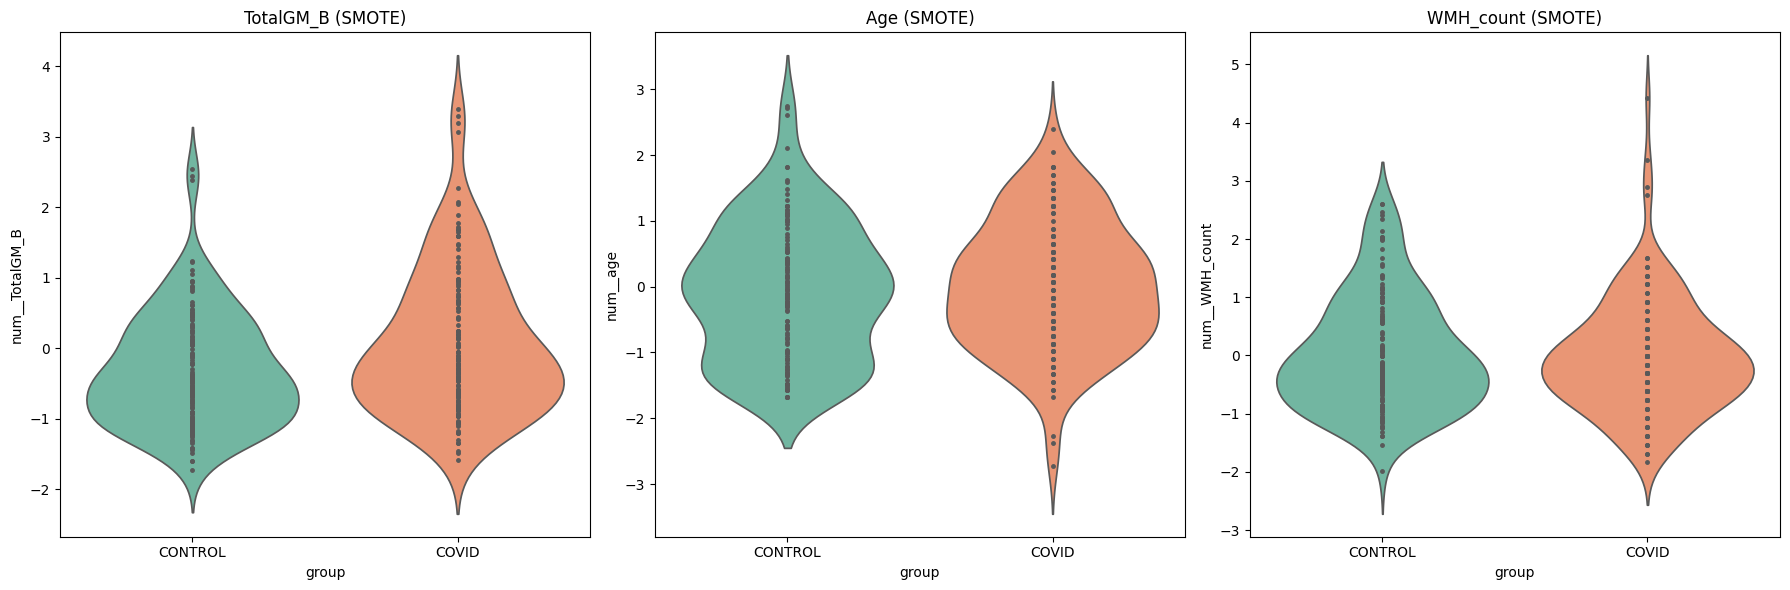

/tmp/ipykernel_2615822/900960183.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2615822/900960183.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2615822/900960183.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


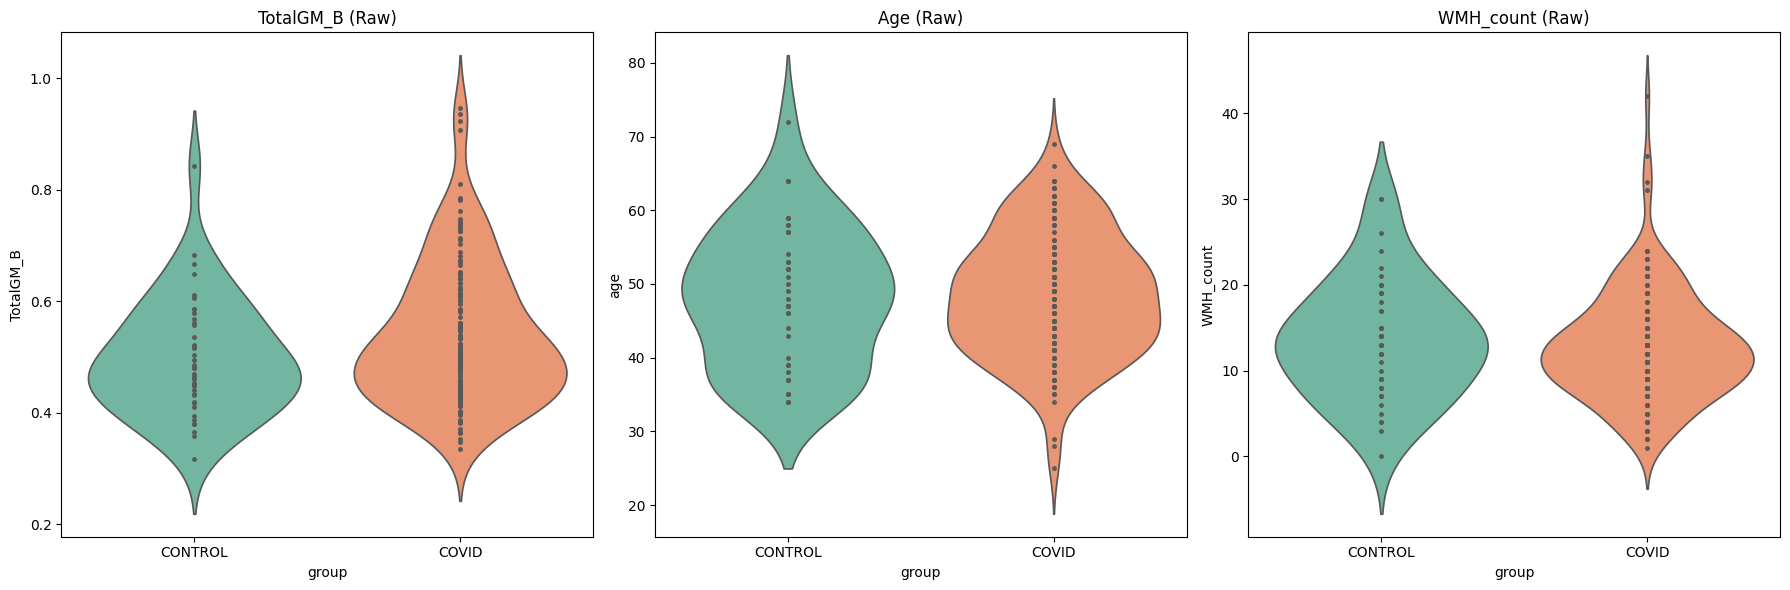

In [4]:
import numpy, matplotlib, seaborn
print(numpy.__version__, matplotlib.__version__, seaborn.__version__)
import seaborn as sns

import matplotlib.pyplot as plt
# Full table:
scov_full_table_smote = scov_table_smote.copy()
scov_full_table_smote['group'] = group_smote 
print(scov_full_table_smote.shape)
print(scov_table.shape)

# Prepare data for violin plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# scov_table_smote: standardized columns
sns.violinplot(
    ax=axes[0],
    x='group',
    y='num__TotalGM_B',
    data=scov_full_table_smote,
    palette='Set2', inner="point"
)
axes[0].set_title('TotalGM_B (SMOTE)')

sns.violinplot(
    ax=axes[1],
    x='group',
    y='num__age',
    data=scov_full_table_smote,
    palette='Set2', inner="point"
)
axes[1].set_title('Age (SMOTE)')

sns.violinplot(
    ax=axes[2],
    x='group',
    y='num__WMH_count',
    data=scov_full_table_smote,
    palette='Set2', inner="point"
)
axes[2].set_title('WMH_count (SMOTE)')

plt.tight_layout()
plt.show()

# scov_table: raw columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.violinplot(
    ax=axes[0],
    x='group',
    y='TotalGM_B',
    data=scov_table,
    palette='Set2', inner="point"
)
axes[0].set_title('TotalGM_B (Raw)')

sns.violinplot(
    ax=axes[1],
    x='group',
    y='age',
    data=scov_table,
    palette='Set2', inner="point"
)
axes[1].set_title('Age (Raw)')

sns.violinplot(
    ax=axes[2],
    x='group',
    y='WMH_count',
    data=scov_table,
    palette='Set2', inner="point"
)
axes[2].set_title('WMH_count (Raw)')

plt.tight_layout()
plt.show()

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance

# Prepare features and labels from SMOTE-augmented data
X_aug = scov_table_shuffled_smote
y_aug = group_shuffled_smote

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42, stratify=y_aug)

# Train SVM classifier
svm_clf = SVC(kernel='rbf', random_state=42)
svm_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute feature importances using permutation importance
result = permutation_importance(svm_clf, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Display feature importances
feature_names = X_aug.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
print(importance_df)

Accuracy: 0.7586206896551724
              precision    recall  f1-score   support

     CONTROL       0.71      0.86      0.78        29
       COVID       0.83      0.66      0.73        29

    accuracy                           0.76        58
   macro avg       0.77      0.76      0.76        58
weighted avg       0.77      0.76      0.76        58

          feature  importance
6  num__TotalGM_B    0.146552
1     num__GM_vol    0.118966
0        num__age    0.096552
2     num__WM_vol    0.086207
5  num__WMH_count    0.079310
3    num__CSF_vol    0.046552
7      cat__sex_F    0.037931
4    num__WMH_vol    0.034483
8      cat__sex_M    0.015517


In [6]:
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels
X = scov_table_main.drop(columns=['group'])
y = scov_table_main['group']

# numeric + categorical data
num_cols = ['age', 'GM_vol', 'WM_vol', 'CSF_vol', 'WMH_vol', 'WMH_count', 'TotalGM_B']#, 'TotalGM_L', 'TotalGM_R']
cat_cols = ['sex']

# Pre‑processing, rescale numeric features and one-hot encode categorical features
preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
# Pre‑processing, rescale numeric features and one-hot encode categorical features
#X_preprocessed = preprocess.fit_transform(X)

# Apply SMOTE with categorical variables
#smote = SMOTENC(categorical_features=[len(num_cols) + i for i in range(len(cat_cols))],
#                sampling_strategy='auto',
#                random_state=42)

# ------------------------------------------------------------------
# 2.  Build pipeline:  preprocess  →  SMOTE  →  SVM
# ------------------------------------------------------------------
pipe = Pipeline(steps=[
    ('prep',  preprocess),
    ('smote', SMOTENC(categorical_features=[len(num_cols) + i for i in range(len(cat_cols))],
                sampling_strategy='auto',
                random_state=42)),
    ('svm',   SVC())                      # kernel & params set later by GridSearch
])
pipe.set_params(svm__class_weight='balanced')
# ------------------------------------------------------------------
# 3.  Hyper‑parameter grid
#     – two kernels   (rbf, poly‑degree3)
#     – a modest sweep of C and gamma
# ------------------------------------------------------------------
param_grid = {
    'svm__kernel': ['rbf', 'poly'],
    'svm__degree': [3],                  # ignored for 'rbf'
    'svm__C':      [0.1, 1, 10],
    'svm__gamma':  ['scale', 0.01, 0.001],
    'svm__class_weight': [None,
                          {'CONTROL': 2, 'COVID': 1},
                          {'CONTROL': 3, 'COVID': 1}]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    scoring='balanced_accuracy',   # good for slight imbalance
                    cv=cv,
                    n_jobs=-1,                     # parallel if CPU allows
                    verbose=2)

grid.fit(X, y)                    # ⬅ whole dataset goes in; CV handles split

print(f"Best model:  {grid.best_params_}")
print(f"CV balanced accuracy: {grid.best_score_:.3f}")

# ------------------------------------------------------------------
# 4.  Final evaluation on a held‑out test set (optional)
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nHeld‑out accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute feature importances using permutation importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Display feature importances
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
print(importance_df)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=0.01, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm

In [7]:
# Now with weights instead of SMOTE
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels
X = scov_table_main.drop(columns=['group'])
y = scov_table_main['group']

# ------------------------------------------------------------------
# 2.  Build pipeline:  preprocess  →  SVM
# ------------------------------------------------------------------
pipe = Pipeline(steps=[
    ('prep',  preprocess),
    ('svm',  SVC(class_weight='balanced'))
])
# ------------------------------------------------------------------
# 3.  Hyper‑parameter grid
#     – two kernels   (rbf, poly‑degree3)
#     – a modest sweep of C and gamma
# ------------------------------------------------------------------
param_grid = {
    'svm__kernel': ['rbf', 'poly'],
    'svm__degree': [3],                  # ignored for 'rbf'
    'svm__C':      [0.1, 1, 10],
    'svm__gamma':  ['scale', 0.01, 0.001]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    scoring='balanced_accuracy',   # good for slight imbalance
                    cv=cv,
                    n_jobs=-1,                     # parallel if CPU allows
                    verbose=2)

grid.fit(X, y)                    # ⬅ whole dataset goes in; CV handles split

print(f"Best model:  {grid.best_params_}")
print(f"CV balanced accuracy: {grid.best_score_:.3f}")

# ------------------------------------------------------------------
# 4.  Final evaluation on a held‑out test set (optional)
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nHeld‑out accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute feature importances using permutation importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Display feature importances
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
print(importance_df)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3

Balanced accuracy (CV mean ± SD): 0.561 ± 0.066
ROC‑AUC          (CV mean ± SD): 0.598 ± 0.058

Odds ratios (L1‑regularised model):
       feature  coef (β)  odds_ratio
num__TotalGM_B     0.581       1.788
  num__WMH_vol     0.000       1.000
   num__WM_vol    -0.033       0.968
num__WMH_count    -0.097       0.907
      num__age    -0.112       0.894
  num__CSF_vol    -0.140       0.870
   num__GM_vol    -0.293       0.746
    cat__sex_M    -0.493       0.610


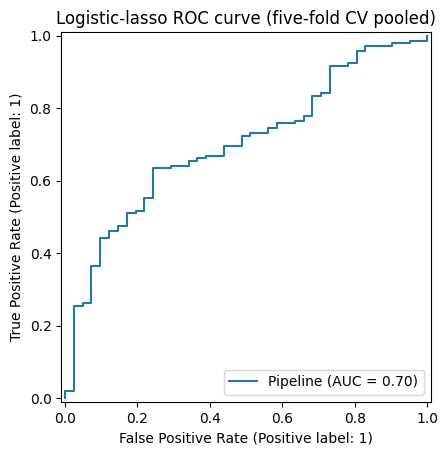

In [10]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve

# ---------------------------------------------------------------
# 0. Load / define your data  (Long‑COVID = 1, Control = 0)
# ---------------------------------------------------------------
# Prepare features and labels
X = scov_table_main.drop(columns=['group'])
y = scov_table_main['group'].map({'CONTROL': 0, 'COVID': 1})  # ensure 0/1 labels

# numeric + categorical data
num_cols = ['age', 'GM_vol', 'WM_vol', 'CSF_vol', 'WMH_vol', 'WMH_count', 'TotalGM_B']#, 'TotalGM_L', 'TotalGM_R']
cat_cols = ['sex']


# ---------------------------------------------------------------
# 1. Pre‑processing: scale numerics, one‑hot categoricals
# ---------------------------------------------------------------
preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)   # avoid dummy trap
])

# ---------------------------------------------------------------
# 2. Logistic‑lasso model  (L1 penalty → automatic feature shrinkage)
# ---------------------------------------------------------------
logit = LogisticRegression(
    penalty='l1',
    solver='saga',
    class_weight='balanced',   # compensates for imbalance
    max_iter=5000,
    random_state=42
)

pipe = Pipeline([
    ('prep', preprocess),
    ('clf',  logit)
])

# ---------------------------------------------------------------
# 3. Cross‑validation performance
# ---------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'bal_acc': 'balanced_accuracy',
    'roc_auc': 'roc_auc',
}

cv_results = cross_validate(pipe, X, y, cv=cv, scoring=scoring,
                            return_estimator=True, n_jobs=-1)

print(f"Balanced accuracy (CV mean ± SD): "
      f"{cv_results['test_bal_acc'].mean():.3f} ± {cv_results['test_bal_acc'].std():.3f}")
print(f"ROC‑AUC          (CV mean ± SD): "
      f"{cv_results['test_roc_auc'].mean():.3f} ± {cv_results['test_roc_auc'].std():.3f}")

# ---------------------------------------------------------------
# 4. Fit on the full data to inspect coefficients / odds ratios
# ---------------------------------------------------------------
pipe.fit(X, y)

# Extract the trained coefficients (after preprocessing)
feature_names = pipe.named_steps['prep'].get_feature_names_out()

coefs = pipe.named_steps['clf'].coef_.flatten()
odds_ratios = np.exp(coefs)           # OR = e^β

odds_df = pd.DataFrame({
    'feature': feature_names,
    'coef (β)': coefs,
    'odds_ratio': odds_ratios
}).sort_values('odds_ratio', ascending=False)

print("\nOdds ratios (L1‑regularised model):")
print(odds_df.to_string(index=False, float_format="%.3f"))

# ---------------------------------------------------------------
# 5. (Optional) Plot ROC curve for visual appraisal
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(pipe, X, y)
plt.title('Logistic‑lasso ROC curve (five‑fold CV pooled)')
plt.show()

In [16]:
from sklearn.linear_model import LogisticRegressionCV

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)   # avoid dummy trap
])

enet = LogisticRegressionCV(
    Cs=np.logspace(-3, 2, 10),             # wider range
    penalty='elasticnet', solver='saga',
    l1_ratios=np.linspace(0.0, 1.0, 11),
    class_weight='balanced',
    cv=5, scoring='balanced_accuracy',
    max_iter=5000, random_state=42
)

pipe_enet = Pipeline([('prep', preprocess), ('clf', enet)])

pipe_enet.fit(X, y)
print("Best balanced‑accuracy:", pipe_enet.named_steps['clf'].scores_[1].mean(axis=0).max())

# Extract the trained coefficients (after preprocessing)
feature_names = pipe_enet.named_steps['prep'].get_feature_names_out()

coefs = pipe_enet.named_steps['clf'].coef_.flatten()
odds_ratios = np.exp(coefs)           # OR = e^β

odds_df = pd.DataFrame({
    'feature': feature_names,
    'coef (β)': coefs,
    'odds_ratio': odds_ratios
}).sort_values('odds_ratio', ascending=False)

print("\nOdds ratios (Elastic-Net‑regularised model):")
print(odds_df.to_string(index=False, float_format="%.3f"))

/home/martin/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martin/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martin/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martin/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martin/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martin/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:34

Best balanced‑accuracy: 0.6067528735632184

Odds ratios (Elastic-Net‑regularised model):
       feature  coef (β)  odds_ratio
num__TotalGM_B     0.152       1.164
      num__age     0.000       1.000
  num__WMH_vol     0.000       1.000
  num__CSF_vol     0.000       1.000
num__WMH_count     0.000       1.000
    cat__sex_M     0.000       1.000
   num__WM_vol    -0.044       0.957
   num__GM_vol    -0.105       0.901


/home/martin/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martin/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [30]:
print(pipe_enet.named_steps['clf'].scores_[1].shape)
# Find the max mean score across folds (axis=0), and get the corresponding C and l1_ratio
scores = pipe_enet.named_steps['clf'].scores_[1]  # shape: (n_folds, n_Cs, n_l1_ratios)
mean_scores = scores.mean(axis=0)  # shape: (n_Cs, n_l1_ratios)
max_idx = np.unravel_index(np.argmax(mean_scores), mean_scores.shape)
max_score = mean_scores[max_idx]
best_C = pipe_enet.named_steps['clf'].Cs_[max_idx[0]]
best_l1_ratio = pipe_enet.named_steps['clf'].l1_ratios_[max_idx[1]]
print(f"Max mean CV score: {max_score:.3f} at C={best_C}, l1_ratio={best_l1_ratio}")

print(f"Scores for each CV ifor the best model {scores[:,max_idx[0], max_idx[1]]}")

print(f"Mean scores for all models for each CV: {scores.mean(axis=(1,2))}")

print(coefs.shape)

(5, 10, 11)
Max mean CV score: 0.607 at C=0.046415888336127795, l1_ratio=0.4
Scores for each CV ifor the best model [0.74712644 0.65086207 0.65732759 0.46982759 0.50862069]
Mean scores for all models for each CV: [0.63190526 0.43215125 0.57307994 0.48706897 0.55278213]
(8,)


In [37]:
# Now only for the best model
from sklearn.linear_model import LogisticRegressionCV

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)   # avoid dummy trap
])

enet = LogisticRegressionCV(
    Cs=[0.04],             # wider range
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0.4],
    class_weight='balanced',
    cv=5, scoring='balanced_accuracy',
    max_iter=5000, random_state=42
)

pipe_enet = Pipeline([('prep', preprocess), ('clf', enet)])

pipe_enet.fit(X, y)
print("Best balanced‑accuracy:", pipe_enet.named_steps['clf'].scores_[1].mean(axis=0).max())

# Extract the trained coefficients (after preprocessing)
feature_names = pipe_enet.named_steps['prep'].get_feature_names_out()

coefs = pipe_enet.named_steps['clf'].coef_.flatten()
odds_ratios = np.exp(coefs)           # OR = e^β

odds_df = pd.DataFrame({
    'feature': feature_names,
    'coef (β)': coefs,
    'odds_ratio': odds_ratios
}).sort_values('odds_ratio', ascending=False)

print("\nOdds ratios (Elastic-Net‑regularised model):")
print(odds_df.to_string(index=False, float_format="%.3f"))

Best balanced‑accuracy: 0.5464559386973179

Odds ratios (Elastic-Net‑regularised model):
       feature  coef (β)  odds_ratio
num__TotalGM_B     0.117       1.124
      num__age     0.000       1.000
  num__WMH_vol     0.000       1.000
  num__CSF_vol     0.000       1.000
num__WMH_count     0.000       1.000
    cat__sex_M     0.000       1.000
   num__WM_vol    -0.027       0.974
   num__GM_vol    -0.086       0.917


In [15]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from tqdm import trange    # progress bar (optional)

# 1.  Get design matrix after preprocessing
X_mat = pipe_enet[:-1].transform(X)                 # numeric array (n × p)
feature_names = pipe_enet.named_steps['prep'].get_feature_names_out()

# 2.  Point-estimate coefficients (already fitted)
logcv = pipe_enet.named_steps['clf']
beta_hat = logcv.coef_.ravel()
odds_hat = np.exp(beta_hat)

# 3.  Bootstrap 95 % CIs (1000 resamples)
n_boot = 1000
boot_coefs = np.zeros((n_boot, X_mat.shape[1]))

for b in trange(n_boot):
    idx = resample(np.arange(len(y)), replace=True, random_state=42 + b)
    Xb, yb = X_mat[idx], y.iloc[idx]

    # Re-fit plain logistic (strongly regularised C) to each bootstrap
    #  --> keeps runtime short and mirrors elastic-net shrinkage
    model = LogisticRegression(
        penalty="elasticnet", solver="saga",
        l1_ratio=0.5, C=0.001, max_iter=5000, class_weight="balanced"
    ).fit(Xb, yb)

    boot_coefs[b] = model.coef_.ravel()

# Compute bootstrap percentile CIs
lo = np.percentile(boot_coefs, 2.5, axis=0)
hi = np.percentile(boot_coefs, 97.5, axis=0)

odds_lo = np.exp(lo)
odds_hi = np.exp(hi)

# Assemble table
or_table = pd.DataFrame({
    "Feature": feature_names,
    "β":        beta_hat.round(3),
    "Odds ratio": odds_hat.round(2),
    "CI 2.5%":   odds_lo.round(2),
    "CI 97.5%":  odds_hi.round(2)
}).sort_values("Odds ratio", ascending=False)

print(or_table.to_string(index=False))

100%|██████████| 1000/1000 [00:01<00:00, 574.88it/s]

       Feature      β  Odds ratio  CI 2.5%  CI 97.5%
num__TotalGM_B  0.152        1.16      1.0       1.0
      num__age  0.000        1.00      1.0       1.0
  num__WMH_vol  0.000        1.00      1.0       1.0
  num__CSF_vol  0.000        1.00      1.0       1.0
num__WMH_count  0.000        1.00      1.0       1.0
    cat__sex_M  0.000        1.00      1.0       1.0
   num__WM_vol -0.044        0.96      1.0       1.0
   num__GM_vol -0.105        0.90      1.0       1.0
